# Fourier construction of single dipole sources

This notebook demonstrates that how the dipole field can be constructed with good accuracy from the Fourier model. It does not attempt to learn any source dependence; only the spatial position.

In [1]:
import jax.random as jr
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
from hypermagnetics import plots
from hypermagnetics.sources import configure
from hypermagnetics.models.hyper_fourier import FourierModel
from hypermagnetics.runner import fit
import matplotlib.pyplot as plt
import scienceplots  # noqa

plt.style.use(["science", "ieee"])

## I. Target definition and data generation

We use the typical form of the field from a single source. The dipole field at $\mathbf{r}$ from a source with moment $\mathbf{m}_i$ and positions $\mathbf{r}_0$ is computed via the scalar potential as $${\mu_0}\mathbf{H}_{\odot}(\mathbf{r}) = -\nabla \underbrace{\overbrace{\frac{1}{2\pi |\mathbf{r}-\mathbf{r_0}|}}^{\text{Surface of 2D ball}}\overbrace{\frac{\mathbf{m}_0\cdot(\mathbf{r}-\mathbf{r_0})}{|\mathbf{r}-\mathbf{r_0}|}}^{\text{dipole term}}}_{\text{scalar potential }\psi_i}$$. 

We'll use a single source example on a grid for training and generalise to non-grid locations.

In [2]:
source_config = {
    "n_samples": 1,
    "lim": 6,
    "res": 100,
}
source = configure(**source_config, n_sources=1, key=jr.PRNGKey(40))

In [3]:
from hypermagnetics.models.hyper_fourier import FourierHyperModel


class FourierDecomposition(FourierModel):
    order: int
    lim: int
    potential: jax.Array

    def __init__(self, order, lim, potential):
        self.order = order
        self.lim = lim
        self.potential = potential.reshape(self.order, self.order)

        # Dummy variables
        self.hypermodel = FourierHyperModel(1, 1, 1, jr.PRNGKey(0))
        self.lfmin = jnp.array([0.0])
        self.lfmax = jnp.array([1.0])

    @property
    def omega(self):
        return 2j * jnp.pi * jnp.fft.fftfreq(self.order, d=self.lim / self.order)

    def prepare_weights(self, sources):
        F = jnp.fft.fft2(self.potential)  # Compute the 2D FFT
        weights, bias = F, F[0, 0]
        return weights, bias

    @eqx.filter_jit
    def fourier_expansion(self, weights, bias, r):
        weights = weights.reshape(self.order, self.order)
        exponents = jnp.exp(self.omega[None, :] * r[0] + self.omega[:, None] * r[1])
        return jnp.sum(weights * exponents).real

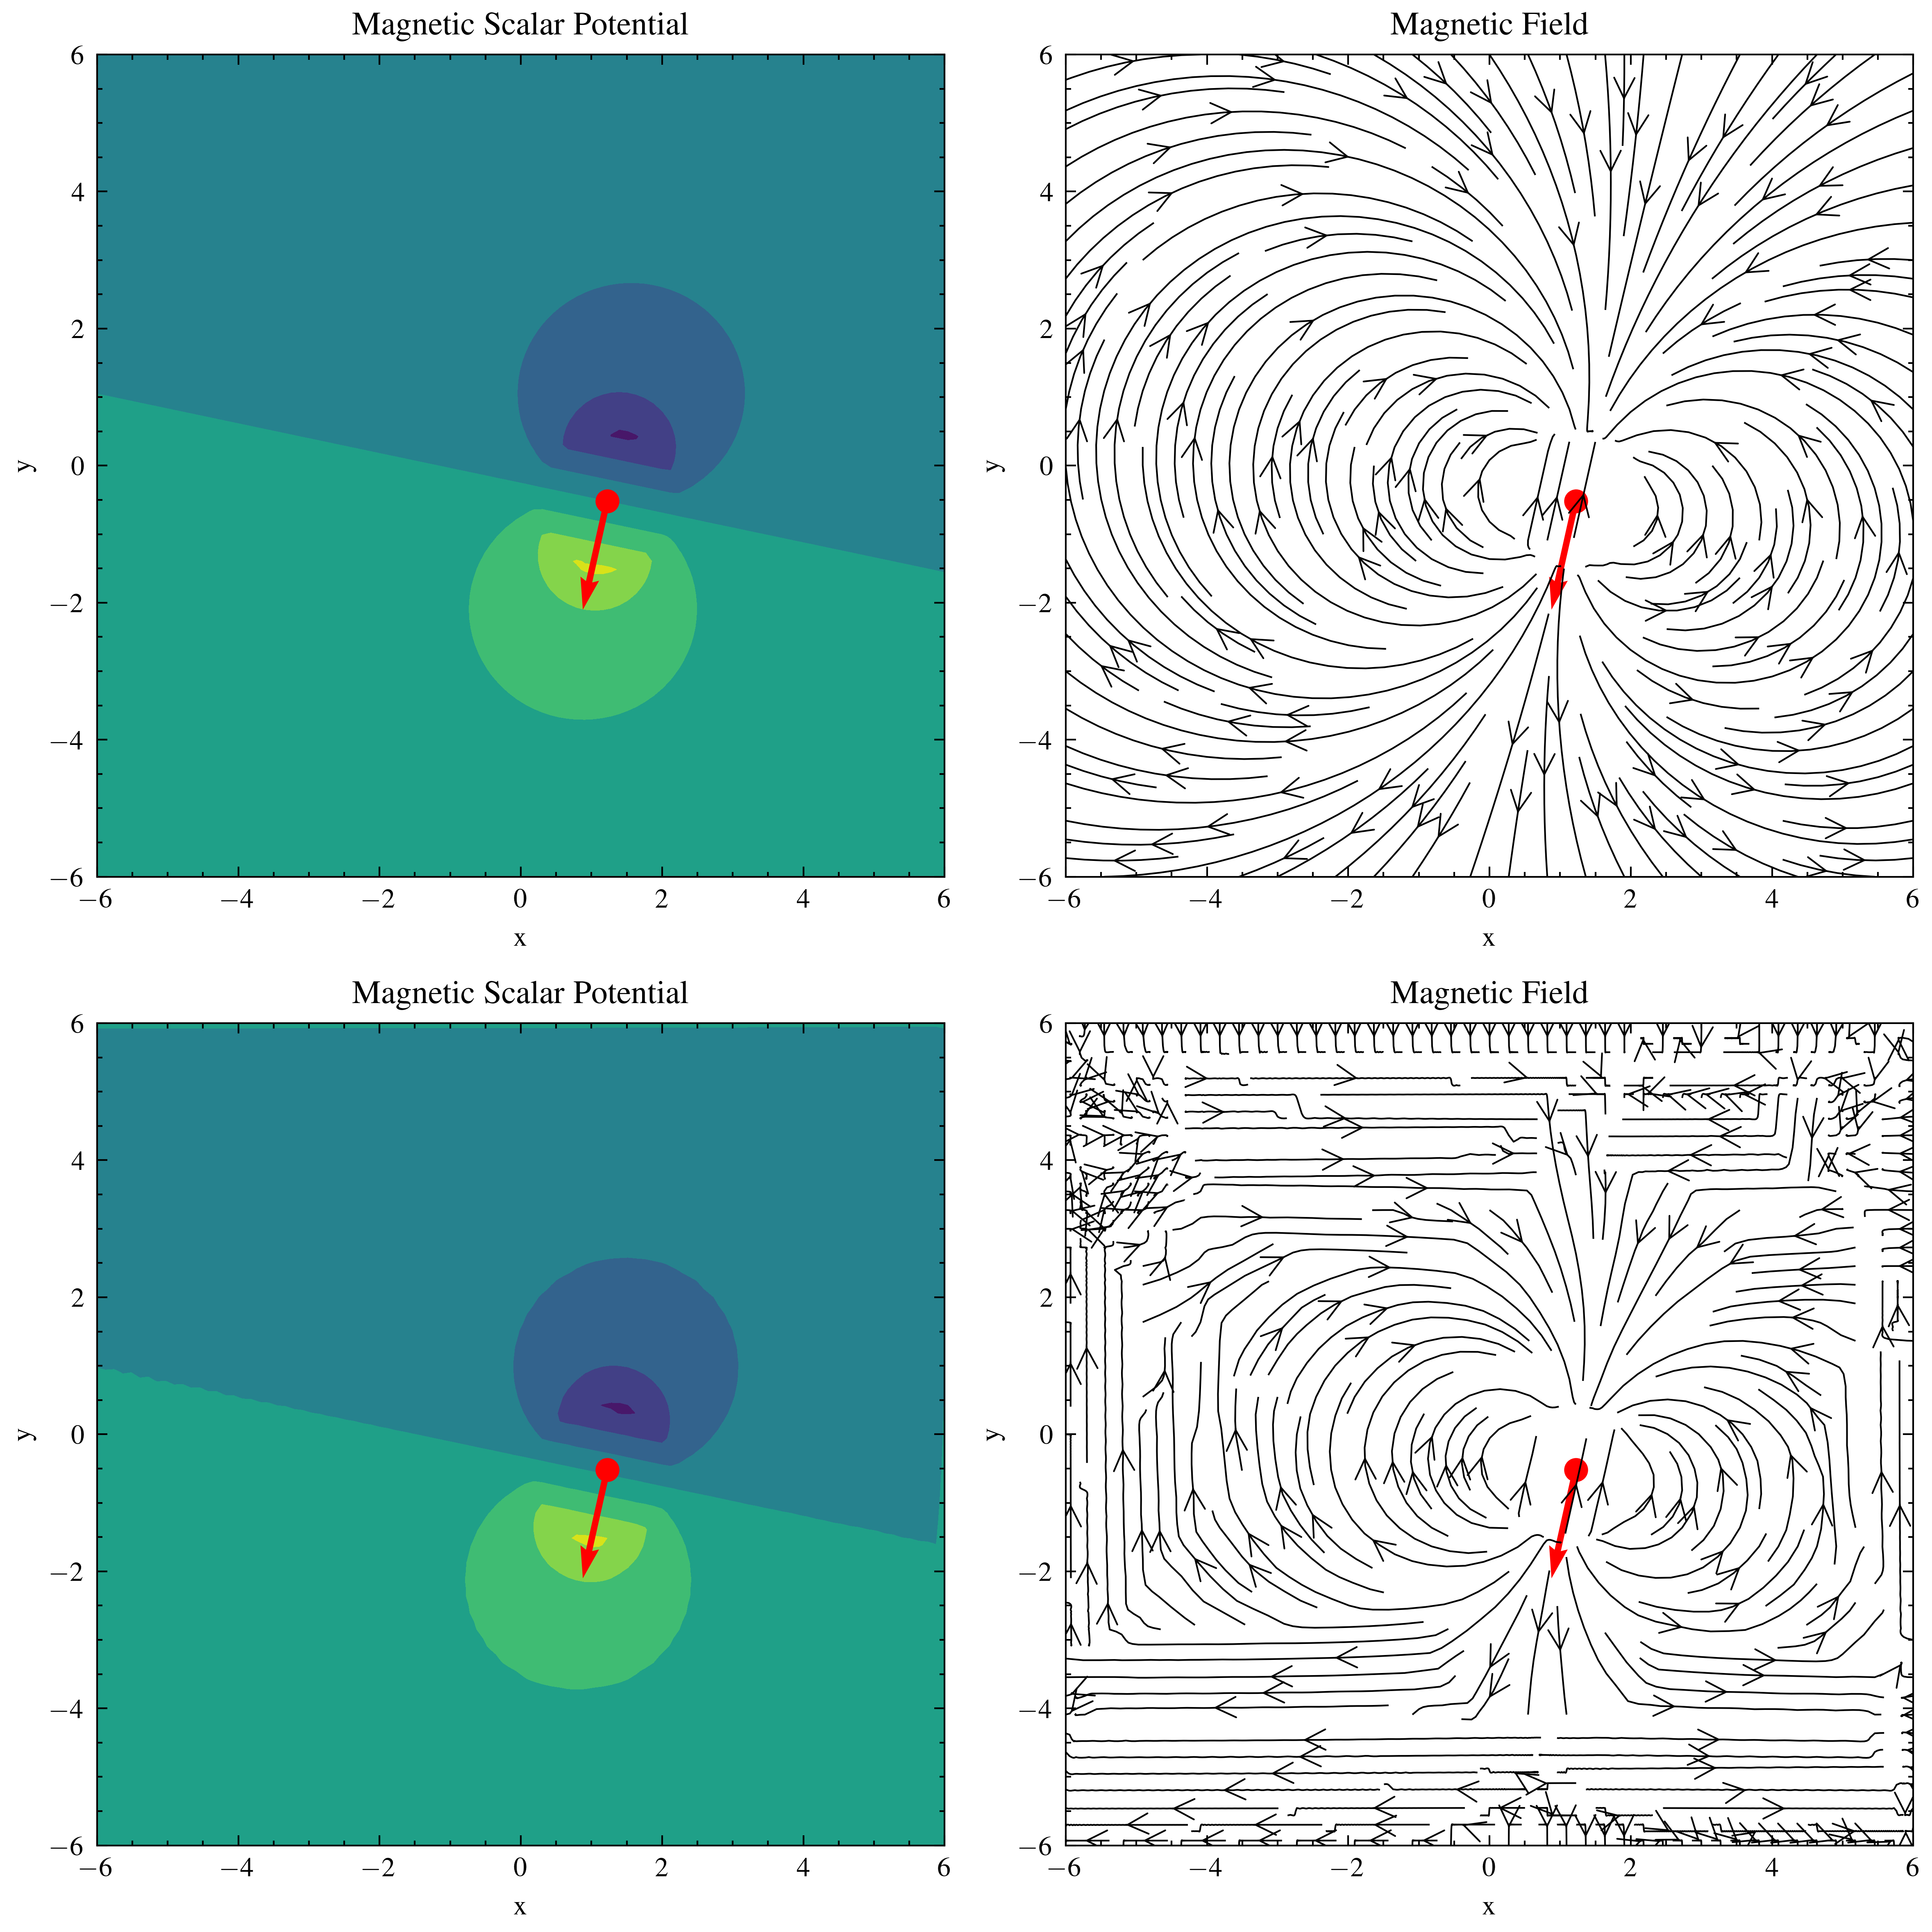

In [4]:
model = FourierDecomposition(
    order=source_config["res"],
    lim=source_config["lim"],
    potential=source["potential"][0],
)

plots(source, model)

## Cartesian reconstruction -- doesn't work

In [ ]:
from hypermagnetics.models.hyper_fourier import FourierHyperModel


class FourierDecomposition(FourierModel):
    order: int
    lim: int
    potential: jax.Array

    def __init__(self, order, lim, potential):
        self.order = order
        self.lim = lim
        self.potential = potential

        # Dummy variables
        self.hypermodel = FourierHyperModel(1, 1, 1, jr.PRNGKey(0))
        self.lfmin = jnp.array([0.0])
        self.lfmax = jnp.array([1.0])

    @property
    def omega(self):
        return jnp.fft.fftfreq(self.order, d=(2 * self.lim / self.order))

    def prepare_weights(self, sources):
        scaling = self.order * self.order
        F = jnp.fft.fft2(self.potential)  # Compute the 2D FFT

        # Compute the mode coefficients
        a = 2 * jnp.real(F) / scaling
        b = -2 * jnp.imag(F) / scaling
        c = 2 * jnp.real(jnp.roll(F, -1, axis=1)) / scaling
        d = -2 * jnp.imag(jnp.roll(F, -1, axis=(0, 1))) / scaling

        # Adjust for DC component
        bias = jnp.real(F[0, 0]) / scaling
        weights = jnp.stack([a, b, c, d], axis=0)

        return weights, bias

In [ ]:
model = FourierDecomposition(order=50, lim=2, potential=source["potential"])

## Learning weights - doesn't work

In [ ]:
class FourierDecomposition(FourierModel):
    hypermodel: jax.Array
    lfmin: jax.Array
    lfmax: jax.Array
    bias: jax.Array
    order: int

    def __init__(self, order):
        self.order = order
        self.lfmin = jnp.ones(1) * -order / 2
        self.lfmax = jnp.ones(1)
        self.bias = jnp.ones(1)
        self.hypermodel = jnp.ones(
            (4 * order**2)
        )  # No hypermodel, just a set of weights

    def prepare_weights(self, sources):
        # Weights don't depend on source information; just fit them.
        return self.hypermodel, self.bias.squeeze()

In [ ]:
model = FourierDecomposition(order=25)
plots(source, model)

In [ ]:
schedule = [
    {"log_learning_rate": -2.0, "epochs": 5000},
    {"log_learning_rate": -3.0, "epochs": 5000},
    {"log_learning_rate": -4.0, "epochs": 5000},
]

for trainer_config in schedule:
    learning_rate = 10 ** trainer_config["log_learning_rate"]
    optim = optax.adamw(learning_rate, b1=0.95)
    model = fit(trainer_config, optim, model, source, source, every=100)

In [ ]:
print(model.lfmin, model.lfmax)
plots(source, model=model)